<center><h1>Restoring and attributing ancient texts with deep neural networks</h1></center>

<center>
<i>Yannis Assael<sup>*</sup>, Thea Sommerschield<sup>*</sup>, Brendan Shillingford, Mahyar Bordbar, John Pavlopoulos, Marita Chatzipanagiotou, Ion Androutsopoulos, Jonathan Prag, Nando de Freitas</i>
</center>
<br>

Ancient history relies on disciplines such as epigraphy, the study of ancient inscribed texts, for evidence of the recorded past. However, these texts, "inscriptions", are often damaged over the centuries, and illegible parts of the text must be restored by specialists, known as epigraphists. This work presents a novel assistive method for providing text restorations using deep neural networks.To the best of our knowledge, Pythia is the first ancient text restoration model that recovers missing characters from a damaged text input. Its architecture is carefully designed to handle long-term context information, and deal efficiently with missing or corrupted character and word representations. To train it, we wrote a non-trivial pipeline to convert PHI, the largest digital corpus of ancient Greek inscriptions, to machine actionable text, which we call PHI-ML. On PHI-ML, Pythia's predictions achieve a 30.1% character error rate, compared to the 57.3% of human epigraphists. Moreover, in 73.5% of cases the ground-truth sequence was among the Top-20 hypotheses of Pythia, which effectively demonstrates the impact of such an assistive method on the field of digital epigraphy, and sets the state-of-the-art in ancient text restoration.
<br><br>

---
### References

When using any of the source code of this project please cite:

<textarea readonly rows=9 cols=90>
@article{asssome2022restoring,
  title={Restoring and attributing ancient texts with deep neural networks},
  author={Assael*, Yannis and Sommerschield*, Thea and Shillingford, Brendan and Bordbar, Mahyar and Pavlopoulos, John and Chatzipanagiotou, Marita and Androutsopoulos, Ion and Prag, Jonathan and de Freitas, Nando},
  journal={Nature},
  year={2022}
}
</textarea>

### License

```
Copyright 2021 the Ithaca Authors

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```
---

In [1]:
#@markdown
%%html
<style>
  * { font-family: Roboto, Noto, sans-serif; }
  h1 { font-weight: 400; }
  p, ol {
    font-size: 16px;
    line-height: 1.6;
  }
  kbd, .btn {
    display: inline-block;
    background: #eee;
    border: 1px solid #aaa;
    border-radius: 3px;
    padding: 0 5px;
    margin: 0 2px;
  }
  .section-name {
    font-weight: 600;
    font-style: italic;
  }
</style>
<h1>Interactive notebook instructions</h1>
<p>Χαῖρε (or welcome) to the Interactive Notebook of Ithaca.</p>
<p>Please follow the instructions below to begin restoring and attributing ancient Greek inscriptions.</p>
<ol>
  <li>
    Execute each of the cells below using <kbd>Shift</kbd>+<kbd>Enter</kbd> to prepare Ithaca.
  </li>
  <li>
    In the <span class="section-name">Setup</span> section, which you should execute but can skip reading, we:
    <ul>
      <li>install the necessary dependencies,</li>
      <li>download the model checkpoint,</li>
      <li>load the imports, and</li>
      <li>create the model.</li>
    </ul>
  </li>
  <li>
    In the section <span class="section-name">Use Ithaca for your research</span>, input 50 to 750 characters of ancient Greek text to process with Ithaca.
  </li>
  <li>
    After executing the <span class="section-name">Restoration</span> section, you will see Ithaca&#39;s top 20 restoration hypotheses ranked by
    probability, along with the saliency map for Ithaca&#39;s top restoration.
  </li>
  <li>
    In the <span class="section-name">Attribution</span> section, one can find:
    <ul>
      <li>a bar chart and geographical map showing the top 10 geographical attribution hypotheses, ranked by probability among 84 regions of the ancient world;</li>
      <li>a categorical distribution over all decades from 800 BCE to 800 CE (the chronological attribution predictive distribution); and</li>
      <li>saliency maps for geographical and chronological attributions.</li>
    </ul>
  </li>
</ol>
<p>If you wish to save your changes or outputs, click <span class="btn">File</span> → <span class="btn">Save a copy in Drive</span>. This is a read-only notebook, so <b>changes are not saved by default</b>.</p>

# Setup (execute these, but you can skip reading them)

In [ ]:
#@title Install Ithaca, download the checkpoint
!pip install -q git+https://github.com/deepmind/ithaca || echo "*** FAILED TO INSTALL ITHACA ***"
!curl --output checkpoint.pkl https://storage.googleapis.com/ithaca-resources/models/checkpoint_v1.pkl

In [3]:
#@title Install geopandas for map visualization
!pip install -q geopandas

In [4]:
#@title Imports
from IPython.core.display import HTML, display

try:
  import ithaca
  import flax
except ModuleNotFoundError:
  display(HTML('<h1><font color="#f00">Failed to import ithaca. Did installation fail above?</font></h1>'))
  raise

import functools

from flax import linen as nn
import folium
import jax
import jinja2
import matplotlib.pyplot as plt
from ml_collections import config_dict
import numpy as np
import pickle as pkl

from ithaca.eval import inference
from ithaca.models.model import Model
from ithaca.util.alphabet import GreekAlphabet

In [5]:
#@title Configuration and auxiliary functions

class dataset_config:
  date_interval = 10
  date_max = 800
  date_min = -800

def get_subregion_name(id, region_map):
  return region_map['sub']['names_inv'][region_map['sub']['ids_inv'][id]]

def bce_ad(d):
  if d < 0:
    return f'{abs(d)} BCE'
  elif d > 0:
    return f'{abs(d)} AD'
  return 0


SALIENCY_SNIPPET_TEMPLATE = jinja2.Template("""
<div class="saliency">
  {% for char, score in pairs -%}
    <span
      style="background-color: rgba(171,71,188,{{'%.2f'|format(score)}});"
      title="Saliency score {{'%.2f'|format(score)}}">{{ char }}</span>
  {%- endfor %}
</div>
""")

SALIENCY_TEMPLATE = jinja2.Template("""<!DOCTYPE html>
<html>
<head>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Roboto+Mono:wght@400&family=Roboto:wght@400&display=swap" rel="stylesheet">
<style>
body { font-family: 'Roboto Mono', monospace; }
.saliency {
  word-wrap: break-word;
  white-space: normal;
}
</style>
</head>
<body>
{{body_html|safe}}
</body>
</html>
""")


def generate_saliency(text, saliency, snippet=False):
  """Generates saliency visualisation."""
  snippet_html = SALIENCY_SNIPPET_TEMPLATE.render(
      pairs=list(zip(text, saliency)))
  if snippet:
    return snippet_html
  return SALIENCY_TEMPLATE.render(body_html=snippet_html)


In [6]:
#@title Load and create model
with open("checkpoint.pkl", "rb") as f:
  checkpoint = pkl.load(f)

model_config = config_dict.ConfigDict(checkpoint['model_config'])
params = jax.device_put(checkpoint['params'])

alphabet = GreekAlphabet()
alphabet.idx2word = checkpoint['alphabet']['idx2word']
alphabet.word2idx = checkpoint['alphabet']['word2idx']

vocab_char_size = checkpoint['model_config']['vocab_char_size']
vocab_word_size = checkpoint['model_config']['vocab_word_size']

region_map = checkpoint['region_map']

forward = functools.partial(Model(**model_config).apply, params)

# Use Ithaca for your research

Input your ancient Greek epigraphic text in the box below to attribute the text to its original place and time of writing, and restore any missing characters. 

Mark **missing characters to be skipped** as **dashes (-)**, and **missing characters to be predicted** as **question marks (?)**.

The text should be between 50 and 750 characters long.

In [7]:
#@title  { run: "auto", vertical-output: true }
text = '\u1F14\u03B4\u03BF\u03BE\u03B5\u03BD \u03C4\u1FC6\u03B9 \u03B2\u03BF\u03C5\u03BB\u1FC6\u03B9 \u03BA\u03B1\u1F76 \u03C4\u1FF6\u03B9 \u03B4\u1F75\u03BC\u03C9\u03B9 \u03BB\u03C5\u03C3\u1F77\u03C3\u03C4\u03C1\u03B1\u03C4\u03BF\u03C2 \u03B5\u1F36\u03C0\u03B5- \u1F10\u03C0\u03B5\u03B9\u03B4\u1F74 \u03B4\u03B9\u03BF\u03C6\u1F71\u03BD\u03B7\u03C2 \u1F00\u03BD\u1F74\u03C1 \u1F00\u03B3\u03B1\u03B8\u1F78\u03C2 \u1F62\u03BD \u03B4\u03B9\u03B1\u03C4\u03B5\u03BB\u03B5\u1FD6 \u03C0\u03B5\u03C1\u1F76 \u03B4\u03B7\u03BB\u1F77\u03BF\u03C5\u03C2 \u03B4\u03B5\u03B4\u1F79\u03C7\u03B8\u03B1\u03B9 \u03C4\u1FF6\u03B9 ----- \u03B4\u03B9\u03BF\u03C6\u1F71\u03BD\u03B7\u03BD \u03BA\u03B1\u03BB\u03BB\u03B9-------- --\u03B7\u03BD\u03B1\u1FD6\u03BF\u03BD \u03C0\u03C1\u1F79\u03BE\u03B5\u03BD\u03BF\u03BD \u03B5\u1F36\u03BD\u03B1\u03B9 \u03B4--------- \u03B1\u1F50\u03C4\u1F78\u03B3 \u03BA\u03B1\u1F76 \u1F10\u03BA\u03B3\u1F79\u03BD\u03BF\u03C5\u03C2 \u03BA-- \u03B5\u1F36\u03BD\u03B1\u03B9 \u03B1\u1F50\u03C4\u03BF\u1FD6\u03C2 \u1F00\u03C4\u1F73\u03BB\u03B5\u03B9\u03B1\u03BD \u1F10\u03BD \u03B4\u1F75\u03BB\u03C9\u03B9 \u03C0\u1F71\u03BD\u03C4\u03C9\u03BD \u03BA\u03B1\u1F76 \u03B3\u1FC6\u03C2 \u03BA\u03B1\u1F76 \u03BF\u1F30\u03BA\u1F77\u03B1\u03C2 \u1F14\u03B3\u03BA\u03C4\u03B7\u03C3\u03B9\u03BD \u03BA\u03B1\u1F76 \u03C0\u03C1\u1F79\u03C3\u03BF\u03B4\u03BF\u03BD \u03C0\u03C1\u1F78\u03C2 \u03C4\u1F74\u03BC \u03B2\u03BF\u03C5\u03BB\u1F74\u03B3 \u03BA\u03B1\u1F76 \u03C4\u1F78\u03BD \u03B4\u1FC6\u03BC\u03BF\u03BD \u03C0\u03C1\u1F7D\u03C4\u03BF\u03B9\u03C2 \u03BC\u03B5\u03C4\u1F70 \u03C4\u1F70 \u1F31\u03B5\u03C1\u1F70 \u03BA\u03B1\u1F76 \u03C4\u1F70 \u1F04\u03BB\u03BB\u03B1 \u1F45\u03C3\u03B1 \u03BA\u03B1\u1F76 \u03C4\u03BF\u1FD6\u03C2 \u1F04\u03BB\u03BB\u03BF\u03B9\u03C2 \u03C0\u03C1\u03BF\u03BE\u1F73\u03BD\u03BF\u03B9\u03C2 \u03BA\u03B1\u1F76 \u03B5\u1F50\u03B5\u03C1\u03B3\u1F73\u03C4\u03B1\u03B9\u03C2 \u03C4\u03BF\u1FE6 \u1F31\u03B5\u03C1\u03BF\u1FE6 \u03B4\u1F73\u03B4\u03BF\u03C4\u03B1\u03B9 \u03C0\u03B1\u03C1\u1F70 ---\u1F77\u03C9\u03BD \u1F00\u03BD\u03B1\u03B3\u03C1\u1F71\u03C8\u03B1\u03B9 \u03B4\u1F72 \u03C4\u1F79\u03B4\u03B5 ?????????\u03B1 \u03C4\u1F74\u03BD \u03B2\u03BF\u03C5\u03BB\u1F74\u03BD \u03B5\u1F30\u03C2 -----------\u03C1\u03B9\u03BF\u03BD \u03C4\u03BF\u1F7A\u03C2 -\u1F72 -----------------------.' #@param {type:"string"}
assert 50 <= len(text) <= 750, "text should be between 50 and 750 chars long, got " + str(len(text))

# Restoration
[Back to top](#scrollTo=oTrYS2DhDmcX)
[Attribution](#scrollTo=M3h8nL22HvTh)



In [8]:
#@title Restoration hypotheses
#@markdown Ithaca’s list of Top-20 restoration hypotheses ranked by probability.
#@markdown
#@markdown This visualization enables the pairing of Ithaca's suggestions with historians'
#@markdown contextual knowledge. Ithaca uses non-sequential beam search, where each beam starts
#@markdown with the prediction scoring the highest confidence, then proceeds iteratively at each timestep to restore
#@markdown the characters with the highest certainty (probability according to the model).
#@markdown 
#@markdown **This step may take several minutes.**

restoration_results = inference.restore(
    text=text,
    forward=forward,
    params=params,
    alphabet=alphabet,
    vocab_char_size=vocab_char_size,
    vocab_word_size=vocab_word_size,
)
prediction_idx = set(i for i, c in enumerate(restoration_results.input_text) if c == '?')

template = jinja2.Template("""<!DOCTYPE html>
<html>
<head>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Roboto+Mono:wght@400&family=Roboto:wght@400&display=swap" rel="stylesheet">
<style>
body {
  font-family: 'Roboto Mono', monospace;
  font-weight: 400;
}
.container {
  overflow-x: scroll;
  scroll-behavior: smooth;
}
table {
  table-layout: fixed;
  font-size: 16px;
  padding: 0;
  white-space: nowrap;
}
table tr:first-child {
  font-weight: bold;
}
table td {
  border-bottom: 1px solid #ccc;
  padding: 3px 0;
}
table td.header {
  font-family: Roboto, Helvetica, sans-serif;
  text-align: right;
  position: -webkit-sticky;
  position: sticky;
  background-color: white;
}
.header-1 {
  background-color: white;
  width: 120px;
  min-width: 120px;
  max-width: 120px;
  left: 0;
}
.header-2 {
  left: 120px;
  width: 50px;
  max-width: 50px;
  min-width: 50px;
  padding-right: 5px;
}
table td:not(.header) {
  border-left: 1px solid black;
  padding-left: 5px;
}
.header-2col {
  width: 170px;
  min-width: 170px;
  max-width: 170px;
  left: 0;
  padding-right: 5px;
}
.pred {
  background: #ddd;
}
</style>
</head>
<body>
Scroll sideways to see all the text if it is wider than the screen.
<button id="btn">jump to restoration area</button>
<div class="container">
<table cellspacing="0">
  <tr>
    <td colspan="2" class="header header-2col">Input text:</td>
    <td>
    {% for char in restoration_results.input_text -%}
      {%- if loop.index0 in prediction_idx -%}
        <span class="pred">{{char}}</span>
      {%- else -%}
        {{char}}
      {%- endif -%}
    {%- endfor %}
    </td>
  </tr>
  <!-- Predictions: -->
  {% for pred in restoration_results.predictions %}
  <tr>
    <td class="header header-1">Hypothesis {{ loop.index }}:</td>
    <td class="header header-2">{{ "%.1f%%"|format(100 * pred.score) }}</td>
    <td>
      {% for char in pred.text -%}
        {%- if loop.index0 in prediction_idx -%}
          <span class="pred">{{char}}</span>
        {%- else -%}
          {{char}}
        {%- endif -%}
      {%- endfor %}
    </td>
  </tr>
  {% endfor %}
</table>
</div>
<script>
document.querySelector('#btn').addEventListener('click', () => {
  const pred = document.querySelector(".pred");
  pred.scrollIntoViewIfNeeded();
});
</script>
</body>
</html>
""")
display(HTML(template.render(
    restoration_results=restoration_results,
    prediction_idx=prediction_idx
)))

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5269: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


In [9]:
#@title Restoration saliency map
#@markdown Saliency maps for each character predicted in Ithaca’s top restoration hypothesis. Highlighted in purple shading are the unique input text features which contributed most to the prediction.

prediction_idx = set(i for i, c in enumerate(restoration_results.input_text) if c == '?')

template = jinja2.Template("""<!DOCTYPE html>
<html>
<head>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Roboto+Mono:wght@400&family=Roboto:wght@400&display=swap" rel="stylesheet">
<style>
body {
  font-family: 'Roboto Mono', monospace;
  font-weight: 400;
}
.container {
  overflow-x: scroll;
  scroll-behavior: smooth;
}
table {
  table-layout: fixed;
  font-size: 16px;
  padding: 0;
  white-space: nowrap;
}
table tr:first-child {
  font-weight: bold;
}
table td {
  border-bottom: 1px solid #ccc;
  padding: 3px 0;
}
table td.header {
  font-family: Roboto, Helvetica, sans-serif;
  position: -webkit-sticky;
  position: sticky;
  background-color: white;
}
.header-1 {
  background-color: white;
  width: 80px;
  min-width: 80px;
  max-width: 80px;
  left: 0;
  text-align: right;
}
.header-2 {
  left: 80px;
  width: 40px;
  max-width: 40px;
  min-width: 40px;
  text-align: center;
  padding-right: 5px;
}
table td:not(.header) {
  border-left: 1px solid black;
  padding-left: 5px;
}
.header-2col {
  width: 120px;
  min-width: 120px;
  max-width: 120px;
  left: 0;
  padding-right: 5px;
}
.pred {
  background: #eee;
}
tr:hover .header-2 {
  background: #bdb;
  font-weight: bold;
}
tr:hover span.restored-pos {
  background: #bdb;
  font-weight: bold;
}
</style>
</head>
<body>
Scroll sideways to see all the text if it is wider than the screen.
<button id="btn">jump to restoration area</button>
<div class="container">
<table cellspacing="0">
  <tr>
    <td colspan="2" class="header header-2col">Input text:</td>
    <td>
    {% for char in restoration_results.input_text -%}
      {%- if loop.index0 in prediction_idx -%}
        <span class="pred">{{char}}</span>
      {%- else -%}
        {{char}}
      {%- endif -%}
    {%- endfor %}
    </td>
  </tr>
  {% for sal in restoration_results.prediction_saliency %}
  <tr>
    <td class="header header-1">Step {{ loop.index }}:</td>
    <td class="header header-2">{{ sal.text[sal.restored_idx].replace(" ", "⎵") }}</td>
    <td>
      {% for char in sal.text -%}
        {%- if loop.index0 == sal.restored_idx -%}
          <span class="pred restored-pos">{{char}}</span>
        {%- elif loop.index0 in prediction_idx and char == "-" -%}
          <span class="pred">{{char}}</span>
        {%- else -%}
          {%- set sal = sal.saliency[loop.index0] -%}
          <span style="background: rgba(171,71,188,{{"%.2f"|format(sal)}})"
          >{{char}}</span>
        {%- endif -%}
      {%- endfor %}
    </td>
  </tr>
  {% endfor %}
</table>
</div>
<script>
document.querySelector('#btn').addEventListener('click', () => {
  const pred = document.querySelector(".pred");
  pred.scrollIntoViewIfNeeded();
});
</script>
</body>
</html>
""")
display(HTML(template.render(
    restoration_results=restoration_results,
    prediction_idx=prediction_idx)))

Input text:,εδοξεν τηι βουληι και τωι δημωι λυσιστρατος ειπε- επειδη διοφανης ανηρ αγαθος ων διατελει περι δηλιους δεδοχθαι τωι ----- διοφανην καλλι-------- --ηναιον προξενον ειναι δ--------- αυτογ και εκγονους κ-- ειναι αυτοις ατελειαν εν δηλωι παντων και γης και οικιας εγκτησιν και προσοδον προς τημ βουληγ και τον δημον πρωτοις μετα τα ιερα και τα αλλα οσα και τοις αλλοις προξενοις και ευεργεταις του ιερου δεδοται παρα ---ιων αναγραψαι δε τοδε ?????????α την βουλην εις -----------ριον τους -ε -----------------------.
Step 1:,ψ
Step 2:,τ
Step 3:,φ
Step 4:,η
Step 5:,μ
Step 6:,σ


# Attribution
[Back to top](#scrollTo=oTrYS2DhDmcX)
[Restoration](#scrollTo=p9EmORGaxn8u)

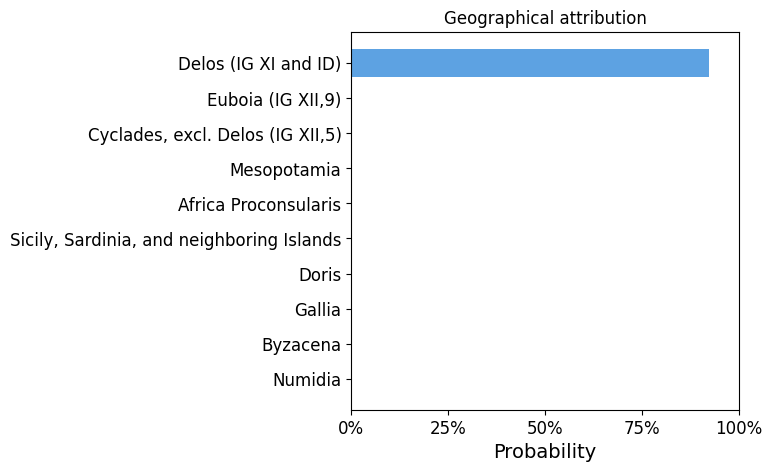

In [10]:
#@title Geographical attribution
#@markdown Bar chart and map distribution for Ithaca's top 10 geographical attribution hypotheses, ranked by probability among 84 regions of the ancient world. The circle size on the map is directly proportional to the prediction’s probability.

attribution_results = inference.attribute(
    text=text,
    forward=forward,
    params=params,
    alphabet=alphabet,
    vocab_char_size=vocab_char_size,
    vocab_word_size=vocab_word_size,
    region_map=region_map
)

locations = []
scores = []
for l in attribution_results.locations[:10]:
  locations.append(get_subregion_name(l.location_id, region_map))
  scores.append(l.score)

# Generate figure
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
y_pos = range(len(locations))
ax.barh(y_pos, scores, color='#5da2e2')

# x-axis
xticks = np.arange(0, 1.1, 0.25)
xticks_str = list(map(lambda x: f'{int(x*100)}%', xticks))
ax.set_xticks(xticks)
ax.set_xticklabels(xticks_str, fontsize=12)

# y-axis
ax.set_yticks(y_pos)
ax.set_yticklabels(locations, fontsize=12)
ax.invert_yaxis()
ax.set_xlabel('Probability', fontsize=14)
ax.set_title('Geographical attribution')

plt.show()

In [11]:
#@title Geographical attribution map
locations_ll = {
    474: {'latitude': 35.20052306, 'longitude': 25.00709816},
    899: {'latitude': 39.6, 'longitude': 22.2},
    1012: {'latitude': 38.84330517, 'longitude': 27.01538508},
    1090: {'latitude': 34.0725, 'longitude': -5.5548},
    1146: {'latitude': 38.5, 'longitude': 57.5},
    1147: {'latitude': 36.607058, 'longitude': 2.1918495},
    1272: {'latitude': 38.482289, 'longitude': 22.501169},
    1324: {'latitude': 34.5, 'longitude': 46.5},
    1377: {'latitude': 41.4407791, 'longitude': 33.25503893},
    1381: {'latitude': 36.52285575, 'longitude': 3.6414695},
    1399: {'latitude': 30.5, 'longitude': 51.5},
    1417: {'latitude': 32.5, 'longitude': 62.5},
    1421: {'latitude': 41.833638, 'longitude': 44.672277},
    1434: {'latitude': 38.75, 'longitude': 22.25},
    1443: {'latitude': 36.833333, 'longitude': 25.9},
    1445: {'latitude': 52.5, 'longitude': -2.5},
    1453: {'latitude': 29.5, 'longitude': 45.5},
    1463: {'latitude': 39.54648402, 'longitude': 20.78770214},
    1474: {'latitude': 32.5, 'longitude': 7.5},
    1477: {'latitude': 37.5, 'longitude': 37.5},
    1480: {'latitude': 32.5, 'longitude': 48.5},
    1482: {'latitude': 39.61497321, 'longitude': 27.87494434},
    1485: {'latitude': 41.25, 'longitude': 21.75},
    1497: {'latitude': 39.5, 'longitude': 40.5},
    1502: {'latitude': 51.6054836, 'longitude': 5.795502625},
    1535: {'latitude': 32.5, 'longitude': 44.5},
    1547: {'latitude': 36.683333000000005, 'longitude': 24.416667},
    1554: {'latitude': 39.16075203, 'longitude': 26.25450897},
    1558: {'latitude': 36.76782566, 'longitude': 66.90106879999999},
    1574: {'latitude': 47.727498, 'longitude': 10.326578},
    1578: {'latitude': 33.17039367, 'longitude': 10.90091267},
    1585: {'latitude': 36.92625341, 'longitude': 25.41590803},
    1589: {'latitude': 32.5, 'longitude': 12.5},
    1590: {'latitude': 36.526222, 'longitude': 37.9555335},
    1595: {'latitude': 40.18650564, 'longitude': -3.736305805},
    1596: {'latitude': 40.683333000000005, 'longitude': 24.65},
    1607: {'latitude': 39.25, 'longitude': 35.75},
    1617: {'latitude': 36.74330537, 'longitude': 29.0371858},
    1621: {'latitude': 38.099043, 'longitude': 22.4314905},
    1624: {'latitude': 38.414, 'longitude': 26.053},
    1626: {'latitude': 37.5, 'longitude': 39.5},
    1627: {'latitude': 36.195597, 'longitude': 27.964125},
    1631: {'latitude': 39.813107, 'longitude': 26.164143},
    1632: {'latitude': 37.61781583, 'longitude': 22.17000731},
    1633: {'latitude': 32.49965333, 'longitude': 20.87174333},
    1635: {'latitude': 46.70543722, 'longitude': 1.013706367},
    1639: {'latitude': 38.22219067, 'longitude': 24.02740133},
    1640: {'latitude': 38.041101, 'longitude': 23.537401000000003},
    1641: {'latitude': 42.5, 'longitude': 22.5},
    1643: {'latitude': 37.6334625, 'longitude': 23.16015635},
    1646: {'latitude': 36.844, 'longitude': 27.17},
    1647: {'latitude': 37.891781, 'longitude': 21.375091},
    1651: {'latitude': 36.990721, 'longitude': 30.98638},
    1653: {'latitude': 38.53, 'longitude': 23.87},
    1654: {'latitude': 38.32544739, 'longitude': 28.2612252},
    1656: {'latitude': 39.13121333, 'longitude': 27.18453033},
    1657: {'latitude': 31.25, 'longitude': 34.75},
    1658: {'latitude': 37.0557778, 'longitude': 21.9809211},
    1659: {'latitude': 38.763022, 'longitude': 21.06285},
    1661: {'latitude': 37.25, 'longitude': 32.75},
    1662: {'latitude': 36.25, 'longitude': 33.25},
    1663: {'latitude': 39.75, 'longitude': 32.75},
    1665: {'latitude': 37.73, 'longitude': 26.84},
    1666: {'latitude': 40.7561925, 'longitude': 31.585856500000002},
    1667: {'latitude': 37.80840845, 'longitude': 22.86776751},
    1668: {'latitude': 32.5, 'longitude': 37.5},
    1669: {'latitude': 36.513532500000004, 'longitude': 29.129310999999998},
    1671: {'latitude': 37.25, 'longitude': 30.75},
    1672: {'latitude': 37.393333, 'longitude': 25.271110999999998},
    1673: {'latitude': 45.5, 'longitude': 22.5},
    1674: {'latitude': 39.13121333, 'longitude': 27.18453033},
    1675: {'latitude': 44.5, 'longitude': 28.5},
    1676: {'latitude': 33.25, 'longitude': 35.25},
    1679: {'latitude': 38.75, 'longitude': 29.75},
    1681: {'latitude': 34.94752576, 'longitude': 33.17932161},
    1682: {'latitude': 37.042901, 'longitude': 27.420201000000002},
    1684: {'latitude': 46.691895, 'longitude': 31.901597},
    1686: {'latitude': 37.67337489, 'longitude': 13.90469368},
    1687: {'latitude': 40.288041, 'longitude': 23.129407999999998},
    1688: {'latitude': 38.06312675, 'longitude': 27.062852000000003},
    1689: {'latitude': 41.891775, 'longitude': 12.486137},
    1691: {'latitude': 38.254405299999995, 'longitude': 23.1821091},
    1694: {'latitude': 19.21140877, 'longitude': 30.56732963},
    1700: {'latitude': 37.97278669, 'longitude': 23.99374594}}

# Compute map center
center_location = np.zeros(2)
for l in attribution_results.locations:
  if l.location_id not in locations_ll:
    continue
  row = locations_ll[l.location_id]
  center_location += np.array([row['latitude'], row['longitude']]) * l.score
 
# Create map
folium_map = folium.Map(location = center_location, 
                 tiles="Stamen Water Color", 
                 zoom_start = 6)

# Create markers
for l in attribution_results.locations:
  if l.location_id not in locations_ll:
    continue
  if l.score < 0.01:
    continue
  row = locations_ll[l.location_id]
  folium.Circle(location=[row['latitude'], row['longitude']], 
                radius=l.score * 50000,
                fill=True,
                popup= f"{l.score * 100:.1f}% - {get_subregion_name(l.location_id, region_map)}",  
                fill_color="darkred",
                color="darkred",
                ).add_to(folium_map)
folium_map

<small>Map tiles by <a href="http://stamen.com">Stamen Design</a> (unmodified), under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://creativecommons.org/licenses/by-sa/3.0">CC BY SA</a>.</small>

In [12]:
#@title Geographical attribution saliency map
#@markdown Saliency map shows unique input text features contributed the most to Ithaca's top geographical
#@markdown attribution hypothesis, where deeper purple indicates a greater contribution.
display(HTML(generate_saliency(
    text=attribution_results.input_text,
    saliency=attribution_results.location_saliency, snippet=False)))

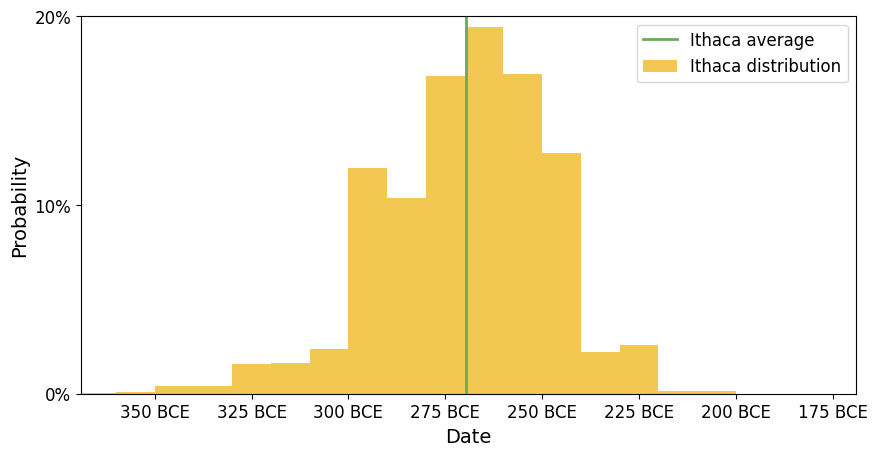

In [13]:
#@title Chronological attribution
#@markdown Ithaca’s chronological attribution hypotheses, visualized as a categorical distribution over decades, in yellow, between 800 BCE and 800 CE. This visualisation enables the handling of date intervals more effectively and aids the interpretability of the hypotheses.

# Compute scores
date_pred_y = np.array(attribution_results.year_scores)
date_pred_x = np.arange(
  dataset_config.date_min + dataset_config.date_interval / 2,
  dataset_config.date_max + dataset_config.date_interval / 2,
  dataset_config.date_interval)
date_pred_argmax = date_pred_y.argmax(
) * dataset_config.date_interval + dataset_config.date_min + dataset_config.date_interval // 2
date_pred_avg = np.dot(date_pred_y, date_pred_x)

# Plot figure
fig = plt.figure(figsize=(10, 5), dpi=100)

plt.bar(date_pred_x, date_pred_y, color='#f2c852', width=10., label='Ithaca distribution')
plt.axvline(x=date_pred_avg, color='#67ac5b', linewidth=2., label='Ithaca average')


plt.ylabel('Probability', fontsize=14)
yticks = np.arange(0, 1.1, 0.1)
yticks_str = list(map(lambda x: f'{int(x*100)}%', yticks))
plt.yticks(yticks, yticks_str, fontsize=12, rotation=0)
plt.ylim(0, int((date_pred_y.max()+0.1)*10)/10)

plt.xlabel('Date', fontsize=14)
xticks = list(range(dataset_config.date_min, dataset_config.date_max + 1, 25))
xticks_str = list(map(bce_ad, xticks))
plt.xticks(xticks, xticks_str, fontsize=12, rotation=0)
plt.xlim(int(date_pred_avg - 100), int(date_pred_avg + 100))
plt.legend(loc='upper right', fontsize=12)

plt.show()

In [14]:
#@title Chronological attribution saliency map
#@markdown Saliency map shows which unique input text features contributed the most to Ithaca’s top chronological attribution hypothesis.
display(HTML(generate_saliency(
    text=attribution_results.input_text,
    saliency=attribution_results.date_saliency)))